# Salary prediction

#  Solution strategy framework for the data science problem
<img src="4Dframework.png" width=800>

# 1- Define the problem and goal

## The problem
The HR manager of a company wants to assign salaries to different posts within the company at the time of publicly advertising the posts. It is crucial that the salaries are within acceptable ranges for the benefit of the company so that the resources of the company are not wasted.

## The goal
The HR manager needs a model which is developed based on an available dataset to help them predict the salary of every post, in order to spend the resources of the company efficiently and create revenue for the company in the long term.

# 2- Discover the data 
Discovering the data is performed through **Exploratory Data Analysis (EDA)**.

In [1]:
def load_data(filePath):
    # Loads csv into DataFrame format in Python
    return pd.read_csv(filePath)

def feature_plot(ds,cl): #ds: dataset   cl: column within dataset
    # Plots the target ('salary') against every feature
    
    # Left plot: distribution of samples of the feature
    # Right plot: change in the value of target (salary) with the feature 
    # (to examine the dependance of the target on the feature)
    pt.figure(figsize = (14,6))
    pt.subplot(1,2,1)
    if ds[cl].dtype == 'int64':
        ds[cl].value_counts().sort_index().plot()
    else:
        # change the categorical variable to category type and order them by the mean salary in each category
        mean = ds.groupby(cl)['salary'].mean()
        ds[cl] = ds[cl].astype('category')
        levels = mean.sort_values().index.tolist()
        ds[cl].cat.reorder_categories(levels, inplace=True)
        ds[cl].value_counts().plot()
    pt.xticks(rotation = 45)
    pt.xlabel(cl)
    pt.ylabel('Counts')
    
    pt.subplot(1,2,2)
    if ds[cl].dtype == 'int64' or cl == 'companyId':
        # plot the mean salary for each category and fill the range (mean - std , mean + std)
        # std = standard deviation
        mean = ds.groupby(cl)['salary'].mean()
        std = ds.groupby(cl)['salary'].std()
        mean.plot()
        pt.fill_between(range(len(std.index)), mean.values-std.values, mean.values + std.values, alpha = 0.1)
    else:
        sn.boxplot(x = cl, y = 'salary', data = ds)
    
    pt.xticks(rotation = 45)
    pt.ylabel('Salary')
    pt.show()
    
def label_encode(ds, cl): # ds : dataset   cl : column
    # Encodes the categories of the column based on the mean value of the salary of every category
    # in order to replace the label of the category
    cat_mean = {}
    cats = ds[cl].cat.categories.tolist()
    for cat in cats:
        cat_mean[cat] = ds[ds[cl] == cat]['salary'].mean()
    ds[cl] = ds[cl].map(cat_mean)
    return ds[cl]

In [2]:
# Importing required libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as pt
import seaborn as sn

## Loading the data

In [3]:
train_dataset_path = 'data/train_dataset.csv'
test_dataset_path = 'data/test_dataset.csv'
results_path = 'data/predicted_salaries.csv'

train_dataset = load_data(train_dataset_path)
test_dataset = load_data(test_dataset_path)

## Step 1: Examining and high level overviewieng the data

In [4]:
train_dataset.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163
5,JOB1362684407692,COMP15,MANAGER,DOCTORAL,COMPSCI,FINANCE,2,31,113
6,JOB1362684407693,COMP15,CFO,NONE,NONE,HEALTH,23,24,178
7,JOB1362684407694,COMP24,JUNIOR,BACHELORS,CHEMISTRY,EDUCATION,9,70,73
8,JOB1362684407695,COMP20,JANITOR,HIGH_SCHOOL,NONE,EDUCATION,1,54,31
9,JOB1362684407696,COMP41,VICE_PRESIDENT,BACHELORS,CHEMISTRY,AUTO,17,68,104


* The column ‘jobId’ seems to be a randomly generated number and hence unique.
* The columns ‘companyId’, ‘jobType’, ‘degree’, ‘major’ and ‘industry’ seem to be categorical columns since there are some repetitions. Therefore, the number of unique categories for each column are expected to be much less than the total number of records.

In [5]:
test_dataset.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97


It can be seen that the test dataset has the same features as the training dataset. Hence, there is no need to delete any features from the training set.



## Step 2: Inspect more detail of the dataset (i.e. length, columns and data types)

In [6]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 68.7+ MB


The training dataset has 1,000,000 entries.

As was expected:
* Categorical columns:
    * ‘companyId’
    * ‘jobType’
    * ‘degree’
    * ‘major’
    * ‘industry’
* Numerical columns:
    * 'jobId'
    * 'yearsExperience'
    * 'milesFromMetropolis'
    * 'salary'

In [7]:
test_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


The test dataset has 1,000,000 entries, with the same columns as the training dataset.

### Create the list of categorical and numerical columns and the target column

‘jobId’ is some randomly generated value, and does not impact the target variable ('salary'). Hence, it is not a feature to be considered in modelling. Therefore, it is not considered in the list of numeric columns as a feature (predictor of the salaries).

In [8]:
numeric_cols = list(train_dataset.select_dtypes(include=[np.number]).columns)
cat_cols = list(train_dataset.select_dtypes(include=['O']).columns)

num_cols = numeric_cols[:-1]
cat_cols = cat_cols[1:]
target_col = numeric_cols[-1]
feature_cols = cat_cols + num_cols

## Step 3: Checking for duplicates and NaN values

In [9]:
train_dataset.duplicated().sum()

0

In [10]:
test_dataset.duplicated().sum()

0

Both the training dataset and the test dataset have no duplicates.

In [11]:
train_dataset.isnull().values.any()

False

In [12]:
test_dataset.isnull().values.any()

False

Both the training dataset and the test dataset have no NaN values, and hence it seems they are nice and clean dataframes.

In case of presence of any duplicates or NaN values, this needed to be investigated further. It should be decided how to handle them, whether or not they should be dropped or be replaced by zero values.

## Step 4: Summarising numerical and categorical variables separately

In [13]:
train_dataset.describe(include = [np.number])

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


The numerical columns have reasonable values and ranges, and there is no need to handle any unexpected data.

In [14]:
train_dataset.describe(include = ['O'])

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684517439,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206




## Step 5: Visualising the target variable (Salary)

C:\Users\Hamid\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


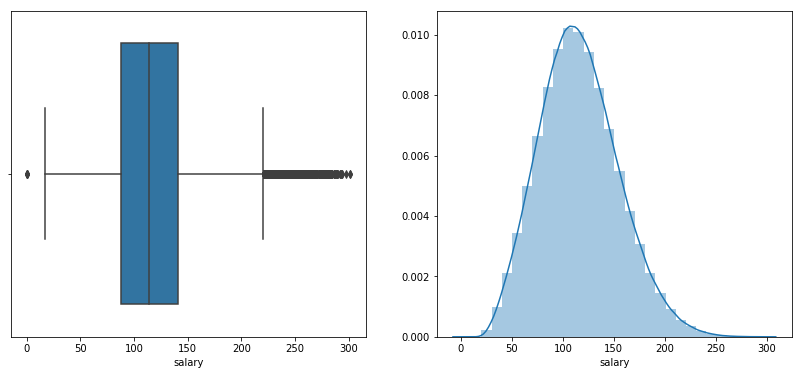

In [15]:
pt.figure(figsize = (14,6))
pt.subplot(1,2,1)
sn.boxplot(train_dataset.salary)
pt.subplot(1,2,2)
sn.distplot(train_dataset.salary, bins = 30)
pt.show()

* The potential outliers need further investigation.

* The ‘salary’ follows similar to a Normal distribution, with a mean around 120.


## Step 6: Dealing with the outliers

### Step 6.1: Using Interquartile Range (IQR) rule to identify potential outliers

In [16]:
st=train_dataset.salary.describe()
print(st)
IQR = st['75%'] - st['25%']
outlier_upper_bound = st['75%'] + 1.5 * IQR
outlier_lower_bound = st['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspicious outliers are {} and {}, respectively.'.format(outlier_upper_bound, outlier_lower_bound))

count    1000000.000000
mean         116.061818
std           38.717936
min            0.000000
25%           88.000000
50%          114.000000
75%          141.000000
max          301.000000
Name: salary, dtype: float64
The upper and lower bounds for suspicious outliers are 220.5 and 8.5, respectively.


Hence, any data entry that has the salary below 8.5 or above 220.5 is considered as potential outlier and needs to be further investigated.

### Step 6.2: Examining potential outliers

This is performed to learn if these outliers are missing, meaningful, and whether to include them in the training set or should they be excluded.

In [17]:
# Outliers below the lower bound
train_dataset[train_dataset.salary < outlier_lower_bound]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


Examining these outliers shows that these are instances of missing/corrupt data, since candidates with doctoral or masters degree, in oil, web or finance industries, with some years of experience should earn a salary. Therefore, these will be removed from the dataset later.

In [18]:
# Outliers above the upper bound
train_dataset.loc[train_dataset.salary > outlier_upper_bound, 'jobType'].value_counts()

CEO               3227
CFO               1496
CTO               1488
VICE_PRESIDENT     603
MANAGER            217
SENIOR              66
JUNIOR              20
Name: jobType, dtype: int64

All these are senior level roles, all the way from CEO down to SENIOR, and it is reasonable that they earn lot of money. However, why candidates in JUNIOR roles should earn high salaries? This needs further investigation to make sure if it is genuine and correct data or should these be dropped from the dataset.

In [19]:
train_dataset[(train_dataset.salary > outlier_upper_bound) & (train_dataset.jobType == 'JUNIOR')]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
1222,JOB1362684408909,COMP40,JUNIOR,MASTERS,COMPSCI,OIL,24,5,225
27710,JOB1362684435397,COMP21,JUNIOR,DOCTORAL,ENGINEERING,OIL,24,3,246
31355,JOB1362684439042,COMP45,JUNIOR,DOCTORAL,COMPSCI,FINANCE,24,0,225
100042,JOB1362684507729,COMP17,JUNIOR,DOCTORAL,BUSINESS,FINANCE,23,8,248
160333,JOB1362684568020,COMP18,JUNIOR,DOCTORAL,BUSINESS,FINANCE,22,3,223
189582,JOB1362684597269,COMP32,JUNIOR,DOCTORAL,BUSINESS,OIL,24,11,221
214606,JOB1362684622293,COMP47,JUNIOR,MASTERS,BUSINESS,FINANCE,22,4,222
303778,JOB1362684711465,COMP51,JUNIOR,MASTERS,ENGINEERING,WEB,24,2,226
348354,JOB1362684756041,COMP56,JUNIOR,DOCTORAL,ENGINEERING,OIL,23,25,226
427593,JOB1362684835280,COMP54,JUNIOR,DOCTORAL,ENGINEERING,FINANCE,23,3,221


Inspection of these suspicious entries shows that these are primarily in oil, finance and web industries. Also, most of them have advanced degrees. Hence, these are genuine correct data since these industries have high salaries even though in their Junior roles. Hence, these data are true outliers and will not be dropped from the dataset.


### Step 6.3: Removing data with zero salaries

In [20]:
train_dataset = train_dataset[train_dataset.salary > outlier_lower_bound]

## Step 7: Plot all the features separately

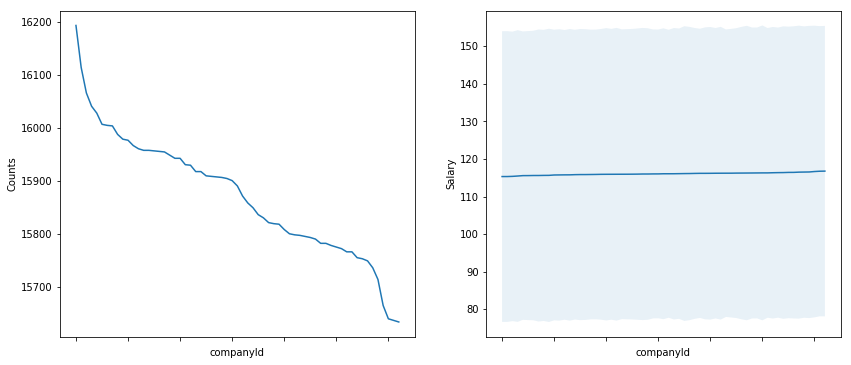

In [21]:
feature_plot(train_dataset, 'companyId')

Conclusion : The straight line shows that this feature is not predictive of the target, meaning the salaries are very weakly associated with these randomly generated numbers.

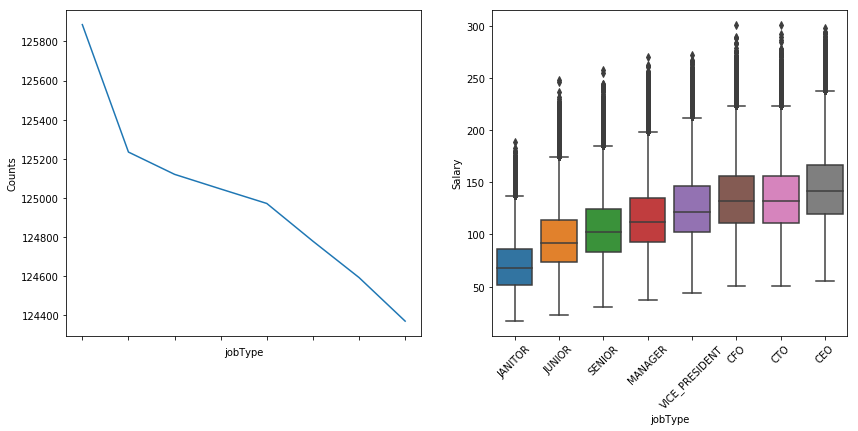

In [22]:
feature_plot(train_dataset, 'jobType')

Conclusion: This shows that the more higher the role, the more salary the person is earning, which is totally reasonable and believable. This feature has definitely impact on the target (salary) and hence will be kept as one of the features in the training dataset.

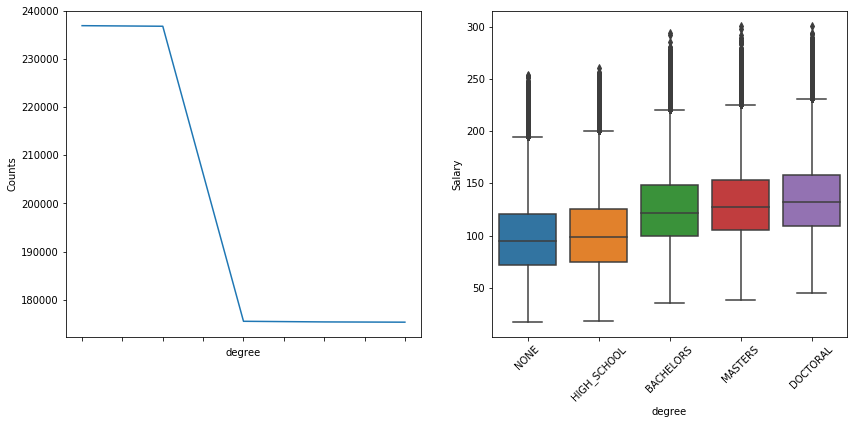

In [23]:
feature_plot(train_dataset, 'degree')

Conclusion: This shows that the more the degree level, the more salary the person is earning, which is completely acceptable and makes sense. This feature has definitely impact on the target (salary) and hence will be kept as one of the features in the training dataset.

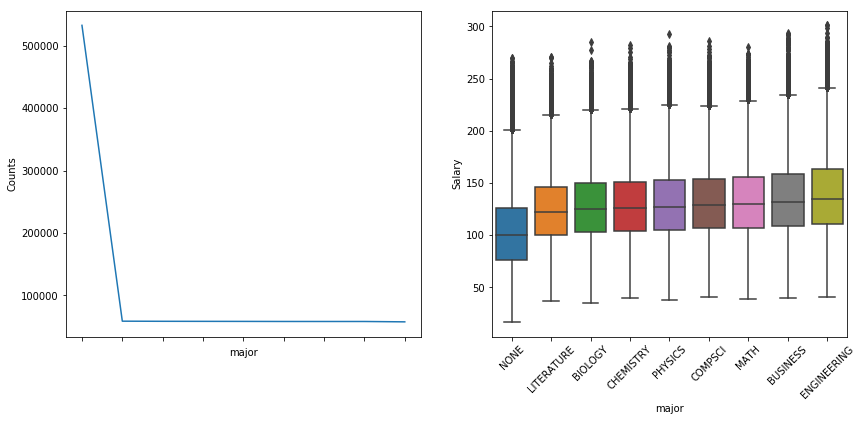

In [24]:
feature_plot(train_dataset, 'major')

Conclusion: Apart from people with NONE degree, the rest of the degrees are earning pretty much the same salary. However, the salaries of engineering, business and maths are slightly higher than other majors. This feature has impact to some extent on the target (salary) and hence will be kept as one of the features in the training dataset.

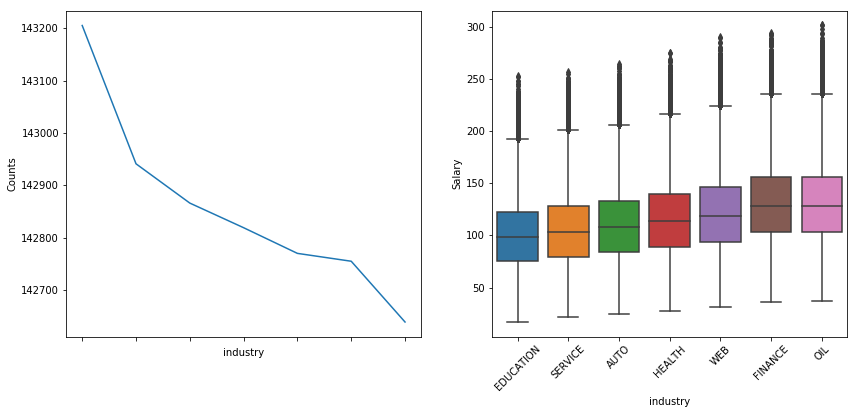

In [25]:
feature_plot(train_dataset, 'industry')

Conclusion: These 2 observations are reasonable and rational. This shows, as expected, that the oil, finance and web has highest salaries. Also, this shows that different industries have different salaries. This feature has definitely impact on the target (salary) and hence will be kept as one of the features in the training dataset.

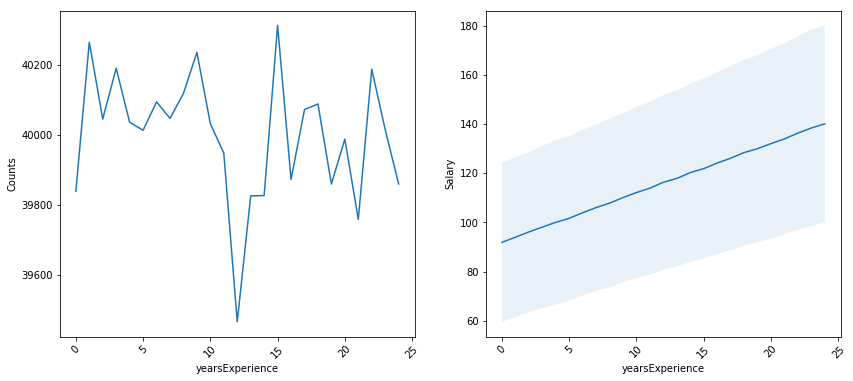

In [26]:
feature_plot(train_dataset, 'yearsExperience')

Conclusion: This shows, as expected, that the more experience the person has, the more salary they earn, which is completely genuine and logical. This feature has definitely impact on the target (salary) and hence will be kept as one of the features in the training dataset.

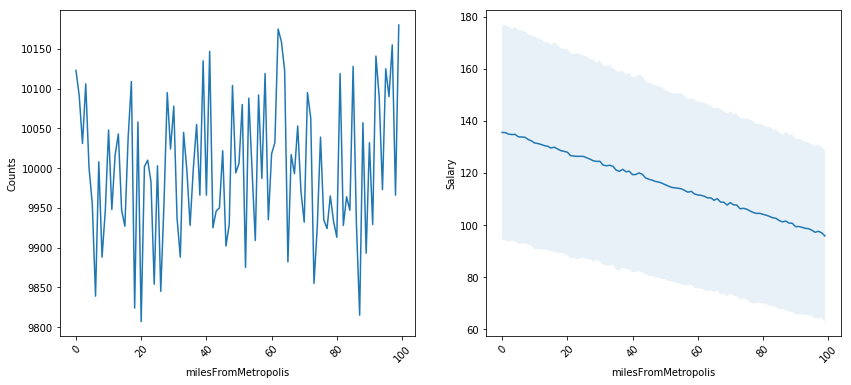

In [27]:
feature_plot(train_dataset, 'milesFromMetropolis')

Conclusion: This shows an inverse relationship between the miles from Metropolis and the salary, which makes perfect sense. This feature has definitely impact on the target (salary) and hence will be kept as one of the features in the training dataset.

## Step 8: Identification of the correlation between all the features and the target

### Step 8.1: Label encoding the categorical variables

In order to compare categorical features with numerical features, the categorical variables are encoded through replacing every category of the column, with the mean value of the associated salaries.

In [28]:
train_dataset_copy = train_dataset[:]
for cl in train_dataset_copy.columns:
    if train_dataset_copy[cl].dtype.name == 'category':
        train_dataset_copy[cl]=label_encode(train_dataset_copy, cl)

### Step 8.2: Develop a map of all the features and target

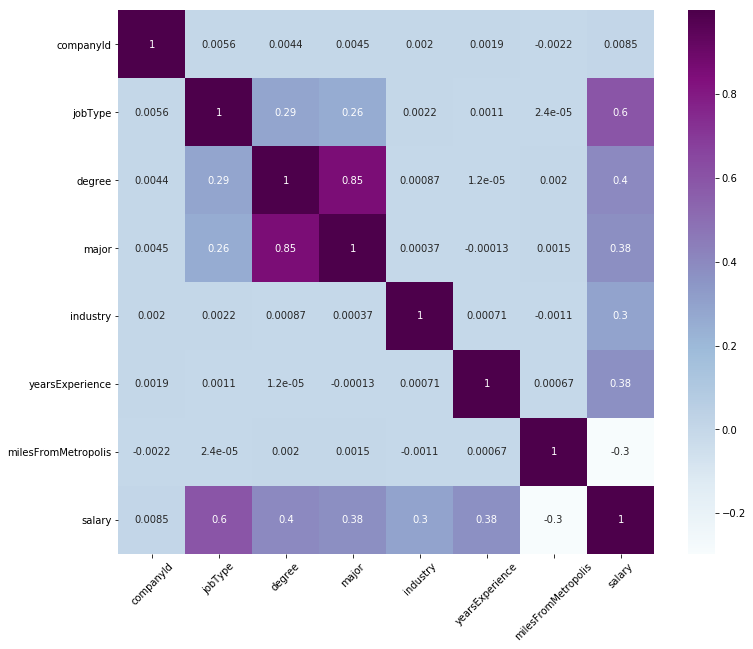

In [29]:
# jobId is not considered since it is a randomly generated value and has no correlation with the salary.
fig = pt.figure(figsize = (12,10))
features = ['companyId', 'jobType', 'degree', 'major', 'industry', 'yearsExperience', 'milesFromMetropolis']
sn.heatmap(train_dataset_copy[features + ['salary']].corr(), cmap = 'BuPu', annot=True)
pt.xticks(rotation = 45)
pt.show()

Conclusions:
* The target variable ('salary') is correlated to all the features except 'companyId'. The correlation with 'companyId' is very weak compared to the rest of the features.

* There is some degree of correlation between 'major' and 'degree'.


# 3- Develop models

In [30]:
def FeatureEng_groupStats(df, cat_cols, target_col):
    # Creates the dataframe of the new engineered features
    groups = df.groupby(cat_cols)
    group_stats_ds = pd.DataFrame({'group_mean': groups[target_col].mean()})
    group_stats_ds['group_max'] = groups[target_col].max()
    group_stats_ds['group_min'] = groups[target_col].min()
    group_stats_ds['group_std'] = groups[target_col].std()
    group_stats_ds['group_median'] = groups[target_col].median()
    group_stats_ds.reset_index(inplace = True)
    group_stats_cols = ['group_mean', 'group_max', 'group_min', 'group_std', 'group_median']
    return group_stats_cols, group_stats_ds
    
def FeatureEng_mergeDFs(df, new_df, cat_cols, group_stats_cols, fillna = False):
    # Merges the dataframe of the new engineered features with train/test dataframe
    new_ds = pd.merge(df, new_df, on = cat_cols, how = 'left')
    if fillna:
        for col in group_stats_cols:
            new_ds[col] = [0 if math.isnan(x) else x for x in new_ds[col]]
    return new_ds

def LabelEncode(df_ref, df_follow, col):
    # Label encodes the categorical column of the dataframe, to be able to feed the dataframe to the ML algorithms
    le = LabelEncoder()
    le.fit(df_ref[col])
    df_ref[col] = le.transform(df_ref[col])
    df_follow[col] = le.transform(df_follow[col])
    return df_ref[col], df_follow[col], le

def shuffle_df(df):
    # Shuffles the dataframe
    return shuffle(df).reset_index()

def cross_val_model(model, feature_df, target_col, n_procs, mean_mse, cv_std):
    # Cross validates the model
    neg_mse = cross_val_score(model, feature_df, target_col, cv = 2, n_jobs = n_procs, scoring = 'neg_mean_squared_error')
    mean_mse[model] = -1.0 * np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)

def print_summary(model, mean_mse, cv_std):
    # Prints a short summary of the model performance
    print('\nmodel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during cross validation:\n', cv_std[model])

In [31]:
# importing required libraries for applying Machine Learning algorithms
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import math

### Feature engineering

* Feature engineering is implemented to inform the model of some of the similarities in the data and hence to boost the performance of the models.
* All the salaries that had the same ‘companyId’, ‘jobType’, ‘degree’, ‘major’, and ‘industry’ were grouped.
* For each aforementioned group, the mean, minimum, maximum, standard deviation and median was calculated as a new dataset with columns: ‘group_mean’, ‘group_min’, ‘group_max’, ‘group_std’ and ‘group_median’ was created.
* The aforementioned dataset was merged with the original dataset and was considered as the training dataset.
* It was carefully noticed that the features that are engineered on the training set are also applicable to the test dataset.

In [32]:
fillna = True
FE_group_stats_cols, FE_group_stats_ds = FeatureEng_groupStats(train_dataset, cat_cols, target_col)
train_dataset_FE = FeatureEng_mergeDFs(train_dataset, FE_group_stats_ds, cat_cols, FE_group_stats_cols, fillna)
test_dataset_FE = FeatureEng_mergeDFs(test_dataset, FE_group_stats_ds, cat_cols, FE_group_stats_cols, fillna)

### Label encoding training and test datasets

In [33]:
Label_encoders={}
for col in cat_cols:
    train_dataset_FE[col], test_dataset_FE[col], Label_encoders[col] = LabelEncode(train_dataset_FE, test_dataset_FE, col)

### Updating the list of features with the added coluumns by feature engineering

In [34]:
cat_cols_FE = cat_cols + FE_group_stats_cols
feature_cols = cat_cols_FE + num_cols

In [35]:
# Shuffling the training dataset
train_dataset_FE = shuffle_df(train_dataset_FE)

In [36]:
# initialise models list and metrics
models = []
mean_mse = {}
cv_std = {}
res = {}

# defining the number of processors
n_procs = 4

# set verbose level
verbose_lvl = 0

### Selected models

Three regression models were selected to predict the target variable (salary), based on the updated list of features:

* Linear Regression
* Random Forest Regressor
* Gradient Boosting Regressor

The Mean Squared Error (MSE) was used as the metric to evaluate and compare the performance of these three models.

In [37]:
# creating models
lr = LinearRegression()

rf = RandomForestRegressor(n_estimators = 80, n_jobs = n_procs, max_depth = 20, min_samples_split = 70, \
                          max_features = 10, verbose = verbose_lvl)

gbm = GradientBoostingRegressor(n_estimators = 40, max_depth = 7, loss = 'ls', verbose = verbose_lvl)

models.extend([lr, rf, gbm])

### Cross validating the models and obtaining the MSE for comparison purposes

In [38]:
print('Cross validating the models')
for model in models:
    cross_val_model(model, train_dataset_FE[feature_cols], train_dataset_FE[target_col], n_procs, mean_mse, cv_std)
    print_summary(model, mean_mse, cv_std)

Cross validating the models

model:
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
Average MSE:
 358.1642253136481
Standard deviation during cross validation:
 0.1167537608164082

model:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features=10, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=70, min_weight_fraction_leaf=0.0,
           n_estimators=80, n_jobs=4, oob_score=False, random_state=None,
           verbose=0, warm_start=False)
Average MSE:
 314.66411543193874
Standard deviation during cross validation:
 0.3913958649033873

model:
 GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_

### Selection of the best model based on the lowest MSE

In [39]:
# selecting the best model based on MSE
bestModel = min(mean_mse, key = mean_mse.get)
print('The best model based on MSE during cross validation:')
print(bestModel)

The best model based on MSE during cross validation:
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)


The **Gradient Boosting Regressor** with the value of MSE of 313.11 is considered as the best model.

### Training the best model on the whole training dataset

In [40]:
bestModel.fit(train_dataset_FE[feature_cols], train_dataset_FE[target_col])

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=7, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=40, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)



# 4- Deploy the best model

In [41]:
def get_model_feature_importances(model, feature_df):
    # Gets and sorts the importance of every feature as a predictor of the target
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    else:
        importances = [0] * len(feature_df.columns)
    
    feature_importances = pd.DataFrame({'feature': feature_df.columns, 'importance': importances})
    feature_importances.sort_values(by = 'importance', ascending = False, inplace = True)
    # set the index to 'feature'
    feature_importances.set_index('feature', inplace = True, drop = True)
    return feature_importances

### Prediction of the salaries of the test dataset using the best model (The Gradient Boosting Regressor)

In [42]:
predicted_salaries = bestModel.predict(test_dataset_FE[feature_cols])

In [43]:
# updating the test dataset with the additional 'predisted_salary' column
test_dataset['predicted_salary'] = predicted_salaries.tolist()

In [44]:
# High level overvieweing the test dataset before writing to the csv file
test_dataset.head(10)

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,predicted_salary
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73,115.806873
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47,87.217377
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9,166.021439
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96,109.380811
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44,107.503555
5,JOB1362685407692,COMP40,CTO,MASTERS,COMPSCI,FINANCE,6,23,159.161684
6,JOB1362685407693,COMP32,SENIOR,MASTERS,COMPSCI,SERVICE,6,32,108.348966
7,JOB1362685407694,COMP11,CEO,BACHELORS,BIOLOGY,SERVICE,9,73,130.653856
8,JOB1362685407695,COMP39,MANAGER,DOCTORAL,PHYSICS,HEALTH,6,78,101.333317
9,JOB1362685407696,COMP22,VICE_PRESIDENT,NONE,NONE,AUTO,23,97,97.603399


In [45]:
# Writing the test dataset to the csv file
test_dataset.to_csv(results_path, index = False)

### Visualisation and comparison of the importance of the considered features

In [46]:
feature_importances = get_model_feature_importances(bestModel, train_dataset_FE[feature_cols])

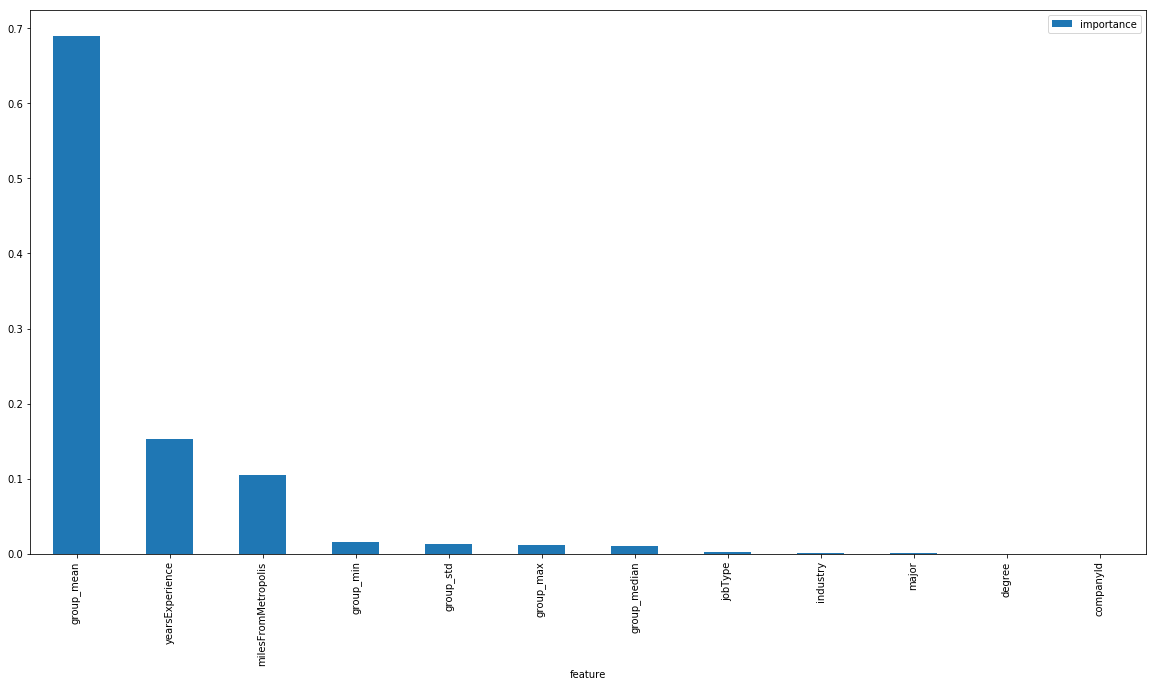

In [47]:
feature_importances.plot.bar(figsize=(20,10))

As can be seen, the following features are the key predictors (have the most importance/impact on the value of the salary):
* group_mean (0.69)
* yearsExperience (0.15)
* milesFromMetropolis (0.10)


# Model improvement
* Feature engineering can be extended to also consider ‘yearsExperience’ and ‘milesFromMetropolis’.
* The performance of the models could have been improved having further features in the original dataset, i.e. ‘recruitType’ (‘contract’ or ‘permanent’), ‘contractType’ (‘full-time’, ‘part-time’), etc.